In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [3]:
train_df = pd.read_csv('data/train.csv', index_col = 0)

### Sale Price Comparision & Log-transformation with right skewed data

[10, 14, 0, 180]

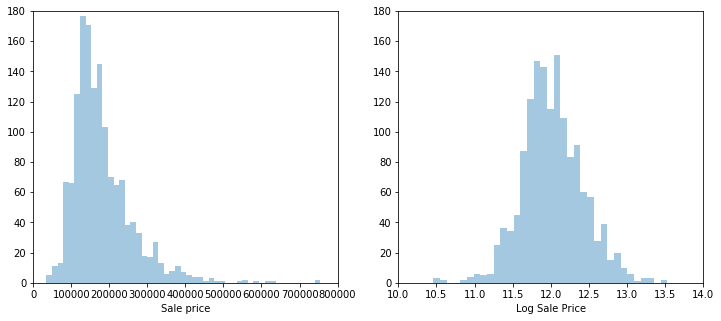

In [4]:
plt.figure(figsize=(12,5))
plt.subplot(121)
sns.distplot(train_df.SalePrice,kde=False)
plt.xlabel('Sale price')
plt.axis([0,800000,0,180])
plt.subplot(122)
sns.distplot(np.log1p(train_df["SalePrice"]),kde=False)
plt.xlabel('Log Sale Price')
plt.axis([10,14,0,180])

In [5]:
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

In [6]:
def transform_housing_data(df):
    """General data-conditioning function to prepare the housing DataFrame for
    analysis. Mostly NaN filling.
    Based on : https://www.kaggle.com/sdevan/top-25-with-ridge-detailed-eda-and-data-cleaning
    """

    fillnone = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                'BsmtFinType2', 'FireplaceQu', 'GarageType', 'GarageFinish',
                'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature',
                'MasVnrType']

    fillzero = ['GarageArea', 'TotalBsmtSF', 'LotFrontage', 'MasVnrArea',
                'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']

    fillmode = ['Electrical', 'KitchenQual', 'SaleType', 'Exterior1st',
                'Exterior2nd', 'Functional', 'MasVnrType', 'MSZoning']

    # has some NaNs. Value is highly correlated with YearBuilt
    df['GarageYrBlt'].fillna(df['YearBuilt'], inplace=True)

    # There seems to be an erroneous value for GarageYrBlt of 2207
    # Based on the YearBuilt being 2006, I assume it should be 2007
    df.loc[df.GarageYrBlt == 2207.0, 'GarageYrBlt'] = 2007.0

    # Convert column to strings. It's categorical data stored as int64
    df['MSSubClass'] = df['MSSubClass'].astype(str)

    # Really only one value present
    df.drop(['Utilities'], axis=1, inplace=True)

    # Apparently this can't be done without looping.
    for colname in fillnone:
        df[colname].fillna('none', inplace=True)

    for colname in fillzero:
        df[colname].fillna(0, inplace=True)

    for colname in fillmode:
        df[colname].fillna(df[colname].mode()[0], inplace=True)
    
    categorical_cols = df.columns[df.dtypes == 'object']
    
    for c in categorical_cols:
        lbl = LabelEncoder() 
        lbl.fit(list(df[c].values)) 
        df[c] = lbl.transform(list(df[c].values))
    
    return df

def plot_correlation():
    corr = train_df.corr()

    # mask = np.zeros_like(corr, dtype=np.bool)
    # mask[np.triu_indices_from(mask)] = True

    # # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    print('Number of features:{}/{}'.format(len(corr.index), len(train_df.columns)))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, cmap=cmap, vmax=.8, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
def plot_missing():
    try:
        cols = corr.index
        missing_data = (train_df[cols].isnull().sum() / len(train_df[cols])) * 100
        missing_data = missing_data.drop(missing_data[missing_data == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'MissingPct':missing_data})

        f, ax = plt.subplots(figsize=(8, 6))
        plt.xticks(rotation='90')
        sns.barplot(x=missing_data.index, y=missing_data.MissingPct)
        plt.xlabel('Features', fontsize=15)
        plt.ylabel('Percent of missing values', fontsize=15)
        plt.title('Percent missing data by feature', fontsize=15)
    except:
        print('No missing data available')

Number of features:37/80
No missing data available


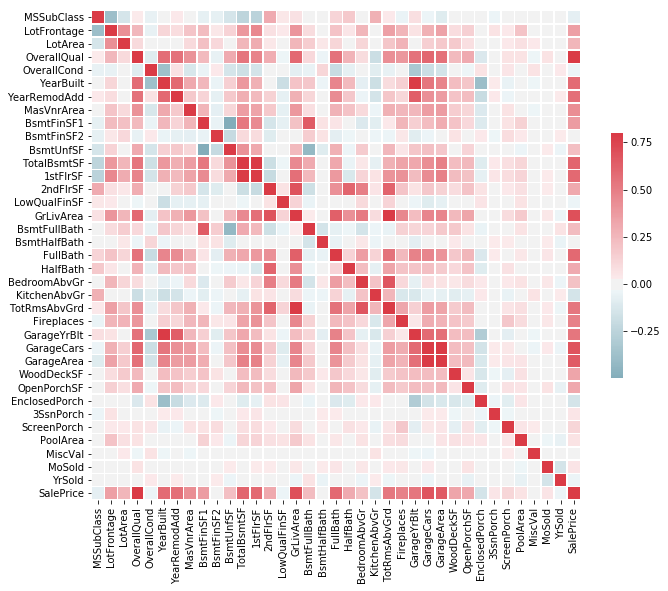

In [7]:
plot_correlation()
plot_missing()

### Transform Categorical Data

In [8]:
train_df = transform_housing_data(train_df)

Number of features:79/79


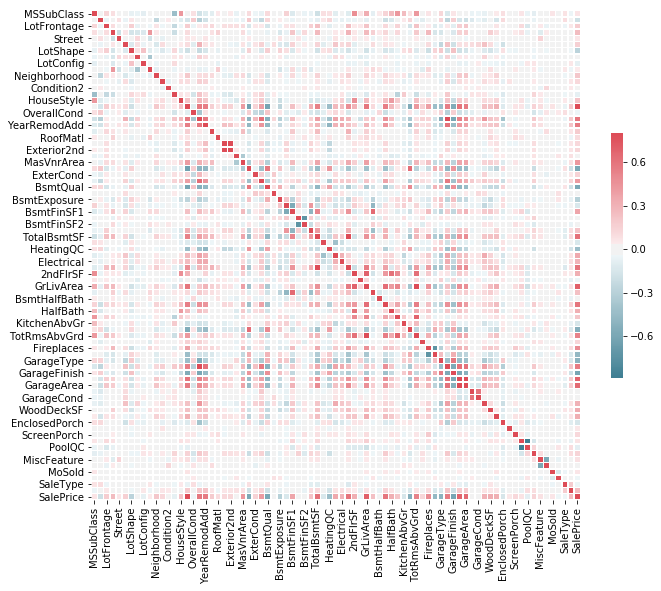

In [9]:
plot_correlation()

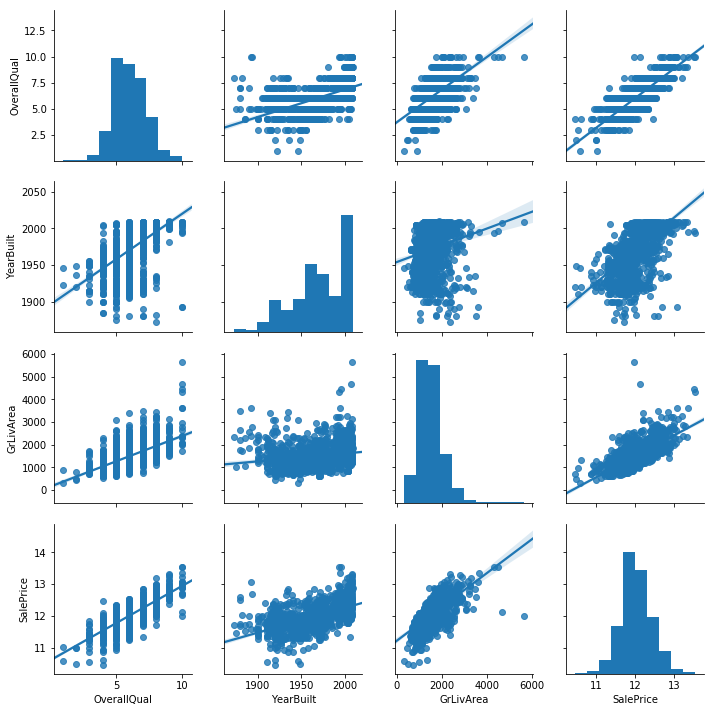

In [20]:
sns.pairplot(train_df[['OverallQual','YearBuilt','GrLivArea','SalePrice']], kind='reg')

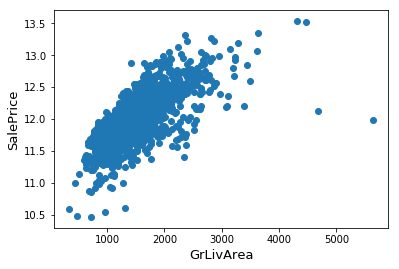

In [22]:
fig, ax = plt.subplots()
ax.scatter(x = train_df['GrLivArea'], y = train_df['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### Regression using Machine Learning Models

In [31]:
## training data
x = train_df.loc[:, train_df.columns != 'SalePrice'].as_matrix()
y = train_df.iloc[:,-1].as_matrix()

In [44]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge,  BayesianRidge, LassoLarsIC, LogisticRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

from scipy.stats import uniform as sp_rand
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

In [32]:
std_sclr = StandardScaler()
x_std = std_sclr.fit_transform(x)
y_int = y.astype(int)

X_train, X_test, y_train, y_test = train_test_split(x_std, y_int, test_size=0.25,random_state=0)

In [43]:
param_grid = {'alpha': sp_rand()}
model = Ridge(normalize=True, max_iter=1e5)
rsearch = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=100)
rsearch.fit(X_train, y_train)
print(rsearch)
# summarize the results of the random parameter search
print(rsearch.best_score_)
print(rsearch.best_estimator_)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=100000.0,
   normalize=True, random_state=None, solver='auto', tol=0.001),
          fit_params=None, iid=True, n_iter=100, n_jobs=1,
          param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1bae7cd0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)
0.668075772358
Ridge(alpha=0.51039293313174017, copy_X=True, fit_intercept=True,
   max_iter=100000.0, normalize=True, random_state=None, solver='auto',
   tol=0.001)


In [54]:
model = LogisticRegression(penalty='l1', C=0.1)
cross_val_score(model,X_train,y_train,cv=5)

array([ 0.8963964 ,  0.89041096,  0.93119266,  0.86238532,  0.92201835])